In [36]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'f', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

import tensorflow as tf
import numpy as np
import os
import fnmatch
import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn import manifold, datasets
from sklearn import feature_selection

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from time import time

import seaborn as sns

COMET WARNING: We detected that you are running inside a Ipython/Jupyter notebook environment but we cannot save your notebook source code. Please be sure to have installed comet_ml as a notebook server extension by running:
jupyter comet_ml enable
COMET INFO: old comet version (1.0.9) detected. current: 1.0.16 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Comet.ml support for Ipython Notebook is limited at the moment, automatic monitoring and stdout capturing is deactivated
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/incnas/general/a38c14f7178c4ab3a98dd09f1684b596

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from shutil import copyfile
import scipy.misc

In [4]:
sns.set(style="white")

## Load Data

In [5]:
path = "data\\sorted\\agg\\ids.csv"
root_dir = "data\\sorted\\agg\\"

In [61]:
data = pd.read_csv(path, index_col=0)
data = data[~data['name'].str.contains("_flipped")]

In [62]:
data = data.sample(frac=1)

In [63]:
data.head()

,name,date,flow_rate,source,peak_val,area,volume,eccentricity,euler_number,extent,mean_intensity,moments,orientation,perimeter,inertia_tensor,cluster,num_peaks,sd,num_local_peaks
52,52,2017.11.17,7200,1.90 s.tifheightmap.mat,7.665951,1717,6732.873700,0.948445,1,0.757055,3.921301,[[1.71700000e+03 7.67380000e+04 4.19110800e+06...,1.495170,197.396970,[[ 47.06751865 30.20988715]\r\n [ 30.20988715...,2,1,2.254912,2
146,146,2017.11.23,1800,63.190 s.tifheightmap.mat,9.263165,7401,25290.418483,0.964196,0,0.252870,3.417162,[[7.40100000e+03 1.12974800e+06 2.06903164e+08...,-1.311872,796.139177,[[ 650.68892314 -1140.5592428 ]\r\n [-1140.55...,2,2,1.669875,11
111,111,2017.11.22,7200,14.60 s.tifheightmap.mat,34.367371,17746,352002.840030,0.978827,1,0.334407,19.835616,[[1.77460000e+04 2.71167500e+06 5.55275639e+08...,-1.226937,1110.933116,[[ 1343.70160609 -2709.8081475 ]\r\n [-2709.80...,0,2,9.923000,28
90,90,2017.11.22,1800,56.00 s.tifheightmap.mat,8.814228,3721,19282.293128,0.912966,1,0.391437,5.182019,[[3.72100000e+03 1.43516000e+05 7.32393000e+06...,-0.712922,336.433550,[[ 591.33133365 -378.9832346 ]\r\n [-378.98323...,0,1,2.715050,7
183,183,2017.11.23,3600,9.40 s.tifheightmap.mat,5.400517,2500,9579.226175,0.776217,1,0.649351,3.831690,[[2.50000000e+03 8.60790000e+04 3.79096100e+06...,-1.498773,214.409163,[[132.95551024 -14.35233616]\r\n [-14.35233616...,2,1,2.005247,2


In [64]:
samples = data.drop(columns=['name','date','source','moments','orientation','inertia_tensor'])
train_data = samples.drop(columns=['flow_rate'])

In [65]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 52 to 84
Data columns (total 13 columns):
flow_rate          201 non-null int64
peak_val           201 non-null float64
area               201 non-null int64
volume             201 non-null float64
eccentricity       201 non-null float64
euler_number       201 non-null int64
extent             201 non-null float64
mean_intensity     201 non-null float64
perimeter          201 non-null float64
cluster            201 non-null int64
num_peaks          201 non-null int64
sd                 201 non-null float64
num_local_peaks    201 non-null int64
dtypes: float64(7), int64(6)
memory usage: 22.0 KB


In [11]:
points = train_data.as_matrix()
normalized = preprocessing.Normalizer().fit_transform(points)
standardize = preprocessing.scale(points)

df_standardize = preprocessing.scale(samples.as_matrix())
df_normalize = preprocessing.Normalizer().fit_transform(samples.as_matrix())
df_raw = samples.as_matrix()

In [12]:
normalized.shape

(201, 12)

## Data Anaylysis

## K-Means

Source: https://www.tensorflow.org/api_docs/python/tf/contrib/factorization/KMeansClustering

In [13]:
def input_fn():
    return tf.train.limit_epochs(tf.convert_to_tensor(standardize, dtype=tf.float32), num_epochs=1)

In [14]:
num_clusters = 3
kmeans = tf.contrib.factorization.KMeansClustering(num_clusters=num_clusters, use_mini_batch=False)

# train
num_iterations = 30
previous_centers = None

# Report hyper params:
hyper_params = {"clusters": num_clusters, "iterations": num_iterations}
experiment.log_multiple_params(hyper_params)

for _ in range(num_iterations):
    kmeans.train(input_fn)
    cluster_centers = kmeans.cluster_centers()
    if previous_centers is not None:
        print('delta:', cluster_centers - previous_centers)
    previous_centers = cluster_centers
    experiment.log_metric("score", kmeans.score(input_fn))
    print('score:', kmeans.score(input_fn))
print('cluster centers:', cluster_centers)

# map the input points to their clusters
cluster_indices = list(kmeans.predict_cluster_index(input_fn))
for i, point in enumerate(points):
    cluster_index = cluster_indices[i]
    center = cluster_centers[cluster_index]
    print('point:', point, 'is in cluster', cluster_index, 'centered at', center)

Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Duo\\AppData\\Local\\Temp\\tmp9ncqt8is', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001CC4009D9B0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Savi

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-22-14:47:58
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-7
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-06-22-14:47:59
INFO:tensorflow:Saving dict for global step 7: global_step = 7, loss = 1554.3767, score = 1554.3767
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-22-14:47:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-7
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-06-22-14:47:59
INFO:tensorflow:Saving dict for global step 7: g

INFO:tensorflow:Loss for final step: 1534.8713.
delta: [[ 0.00414997  0.01267058  0.00550807  0.00292549  0.00108735 -0.022634
   0.00341409  0.01431766  0.00202215  0.02632473  0.00093693  0.01385958]
 [ 0.02529103  0.05486083  0.05758965  0.0011957  -0.04228956  0.03308189
   0.02675024  0.04346561 -0.06389812 -0.02925217  0.02882715  0.04272115]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-22-14:48:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-15
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-06-22-14:48:08
INFO:tensorflow:Saving dict for global step 15: global_step = 1

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-06-22-14:48:17
INFO:tensorflow:Saving dict for global step 23: global_step = 23, loss = 1534.2231, score = 1534.2231
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-22-14:48:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-23
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-06-22-14:48:17
INFO:tensorflow:Saving dict for global step 23: global_step = 23, loss = 1534.2231, score = 1534.2231
score: 1534.2231
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:t

INFO:tensorflow:Saving dict for global step 31: global_step = 31, loss = 1534.2231, score = 1534.2231
score: 1534.2231
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-31
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 32 into C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt.
INFO:tensorflow:loss = 1534.2231, step = 31
INFO:tensorflow:Saving checkpoints for 33 into C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt.
INFO:tensorflow:Loss for final step: 1534.2231.
delta: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-2

delta: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-22-14:48:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-41
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-06-22-14:48:37
INFO:tensorflow:Saving dict for global step 41: global_step = 41, loss = 1534.2231, score = 1534.2231
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-22-14:48:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-41
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done 

INFO:tensorflow:Starting evaluation at 2018-06-22-14:48:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-49
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-06-22-14:48:46
INFO:tensorflow:Saving dict for global step 49: global_step = 49, loss = 1534.2231, score = 1534.2231
score: 1534.2231
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-49
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 50 into C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt.
INFO:tensorflow:loss = 1534.2231, step = 49
INFO:tensorflow:Saving che

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 58 into C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt.
INFO:tensorflow:loss = 1534.2231, step = 57
INFO:tensorflow:Saving checkpoints for 59 into C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt.
INFO:tensorflow:Loss for final step: 1534.2231.
delta: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-22-14:48:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Duo\AppData\Local\Temp\tmp9ncqt8is\model.ckpt-59
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2018-06-22-14:48:55
INFO:tensorflow:Saving dict for global step 59: gl

  0.45067427 -0.3068786  -0.8424378  -0.24166523  0.47381344 -0.31997177]
point: [1.22832082e+01 1.32640000e+04 7.36845247e+04 9.83173217e-01
 1.00000000e+00 6.41702951e-01 5.55522653e+00 7.74499567e+02
 0.00000000e+00 1.00000000e+00 3.11306670e+00 1.30000000e+01] is in cluster 1 centered at [ 0.33428818  2.0469162   1.5066103   0.42331296 -0.8602025  -1.0529608
  0.3233577   2.0033946  -0.37385175  1.225974    0.19424784  1.9730499 ]
point: [5.60843163e+00 9.88000000e+02 3.04039691e+03 9.12812325e-01
 1.00000000e+00 5.48888889e-01 3.07732480e+00 1.54953319e+02
 2.00000000e+00 1.00000000e+00 1.76861339e+00 1.00000000e+00] is in cluster 0 centered at [-0.65112716 -0.3804322  -0.42585835  0.16111198  0.15342435 -0.1250024
 -0.64185834 -0.25780663  1.1277539  -0.09311876 -0.62927866 -0.23261198]
point: [1.95131872e+01 6.46800000e+03 4.38068159e+04 5.92409834e-01
 1.00000000e+00 5.79569892e-01 6.77285342e+00 4.77203102e+02
 0.00000000e+00 2.00000000e+00 4.52659462e+00 1.20000000e+01] is in

  0.00000000e+00  1.00000000e+00  4.03604305e+00  2.20000000e+01] is in cluster 1 centered at [ 0.33428818  2.0469162   1.5066103   0.42331296 -0.8602025  -1.0529608
  0.3233577   2.0033946  -0.37385175  1.225974    0.19424784  1.9730499 ]
point: [1.17141763e+01 5.42100000e+03 3.57201494e+04 8.25310337e-01
 1.00000000e+00 6.27721167e-01 6.58921775e+00 3.34249783e+02
 0.00000000e+00 1.00000000e+00 3.68596381e+00 4.00000000e+00] is in cluster 2 centered at [ 0.45555183 -0.21602423 -0.03746455 -0.24449776  0.09615728  0.3783772
  0.45067427 -0.3068786  -0.8424378  -0.24166523  0.47381344 -0.31997177]
point: [8.90595787e+00 4.17700000e+03 2.14750997e+04 7.94214608e-01
 1.00000000e+00 7.24419008e-01 5.14127358e+00 2.82551299e+02
 0.00000000e+00 1.00000000e+00 2.69578710e+00 5.00000000e+00] is in cluster 2 centered at [ 0.45555183 -0.21602423 -0.03746455 -0.24449776  0.09615728  0.3783772
  0.45067427 -0.3068786  -0.8424378  -0.24166523  0.47381344 -0.31997177]
point: [1.36397740e+01 4.45200

point: [9.31234703e+00 6.86100000e+03 3.17355086e+04 8.72522057e-01
 1.00000000e+00 3.24458526e-01 4.62549317e+00 6.75210245e+02
 0.00000000e+00 2.00000000e+00 2.38438179e+00 1.00000000e+01] is in cluster 1 centered at [ 0.33428818  2.0469162   1.5066103   0.42331296 -0.8602025  -1.0529608
  0.3233577   2.0033946  -0.37385175  1.225974    0.19424784  1.9730499 ]
point: [7.13444668e+00 2.83100000e+03 9.73064798e+03 9.07942774e-01
 1.00000000e+00 4.72305639e-01 3.43717696e+00 2.93220346e+02
 2.00000000e+00 1.00000000e+00 1.98360920e+00 3.00000000e+00] is in cluster 0 centered at [-0.65112716 -0.3804322  -0.42585835  0.16111198  0.15342435 -0.1250024
 -0.64185834 -0.25780663  1.1277539  -0.09311876 -0.62927866 -0.23261198]
point: [1.10087169e+01 1.18160000e+04 5.57980920e+04 9.84400328e-01
 1.00000000e+00 2.30358327e-01 4.72224881e+00 1.30797980e+03
 0.00000000e+00 3.00000000e+00 2.20447725e+00 2.10000000e+01] is in cluster 1 centered at [ 0.33428818  2.0469162   1.5066103   0.42331296 -0

### Save Result

In [15]:
data['cluster'] = cluster_indices
#data.to_csv(path)

In [16]:
for i in range(num_clusters):
    directory = os.path.join(root_dir, str(i)+"_"+str(num_clusters))

    if not os.path.exists(directory):
        os.makedirs(directory)

In [17]:
for index, row in data.iterrows():
    name = row['name']
    cluster = row['cluster']
    
    copyfile(f'{root_dir}{name}.npy', f'{root_dir}{cluster}_{num_clusters}\\{name}.npy')
    
    image_array = np.load(f'{root_dir}{cluster}_{num_clusters}\\{name}.npy')
    scipy.misc.imsave(f'{root_dir}{cluster}_{num_clusters}\\{name}.jpg', image_array)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


## Visualisations:

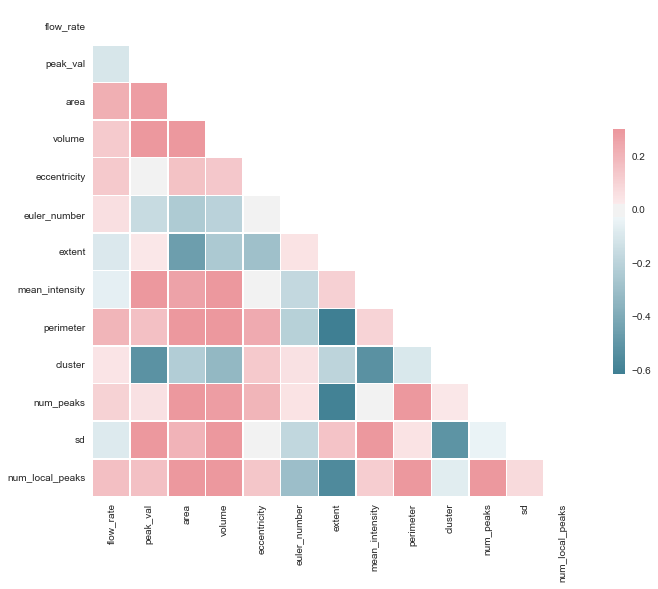

In [18]:
# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 #columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = pd.DataFrame(data=df_raw,columns=list(samples)).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

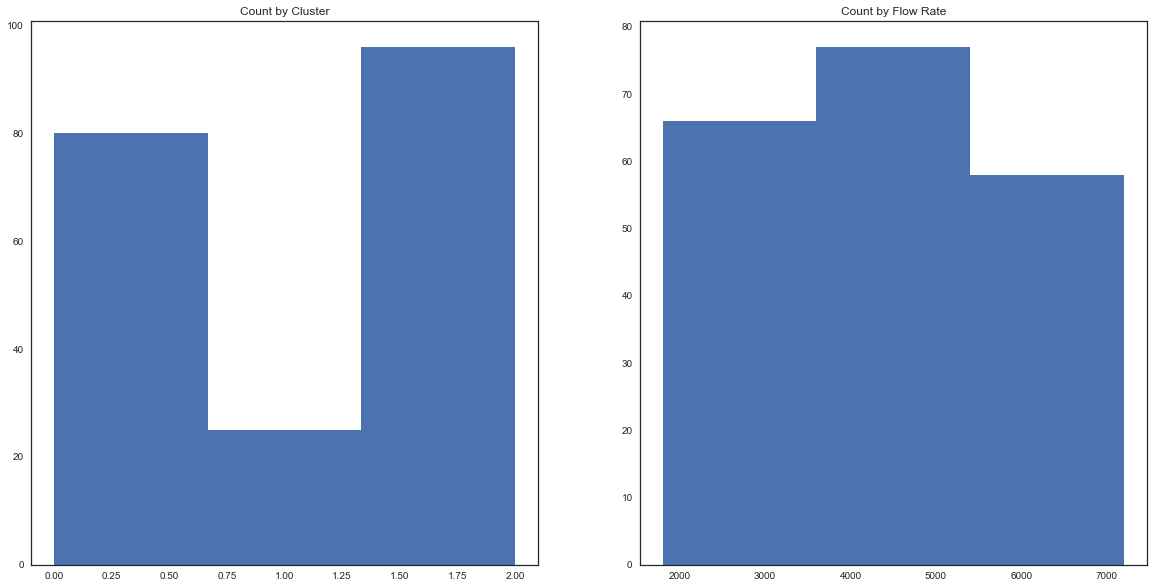

In [38]:
t = data[data['flow_rate']==1800]
u = data[data['flow_rate']==3600]
v = data[data['flow_rate']==7200]

a = data[data['cluster']==0]
b = data[data['cluster']==1]
c = data[data['cluster']==2]

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Peaks by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')

plt.subplot(121)
plt.title("Num Peaks by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')'''

plt.subplot(121)
plt.title("Count by Cluster")
plt.hist(data['cluster'], bins=3)

plt.subplot(122)
plt.title("Count by Flow Rate")
plt.hist(data['flow_rate'], bins=3)

plt.show()

Number of different blobs as identified by Otsu's

Num Peaks by Flow Rate: 
1800: [59, 7, 0]
3600: [66, 9, 2]
7200: [47, 9, 2]


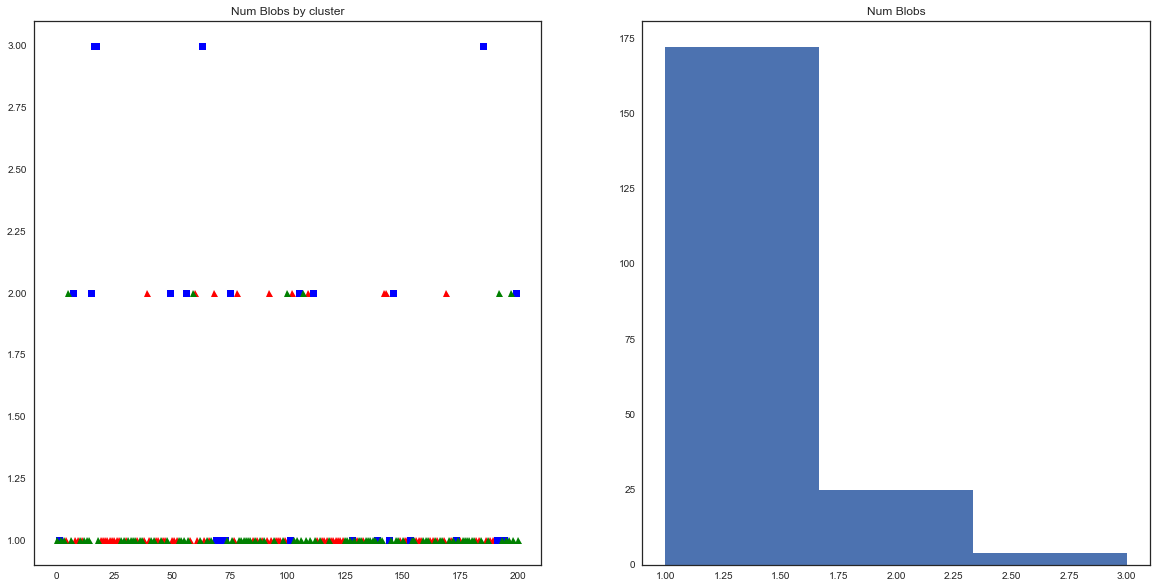

In [39]:
t = data[data['cluster']==0]['num_peaks']
u = data[data['cluster']==1]['num_peaks']
v = data[data['cluster']==2]['num_peaks']

N = 3

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

a = data[data['flow_rate']==1800]
a = a.groupby('num_peaks').size().tolist()
a.append(0)

b = data[data['flow_rate']==3600]
b = b.groupby('num_peaks').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('num_peaks').size().tolist()

print("Num Peaks by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''p1 = plt.bar(ind, a, width)
p2 = plt.bar(ind, b, width,bottom=a)
p3 = plt.bar(ind, c, width,bottom=b)

plt.xticks(ind, ('1800', '3600', '7200'))

plt.legend((p1[0], p2[0], p3[0]), ('1', '2', '3'))

plt.subplot(131)
plt.title("Num Blobs by flow rate")
plt.plot(a, 'r^', b, 'bs', c, 'g^')'''

plt.subplot(121)
plt.title("Num Blobs by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.subplot(122)
plt.title("Num Blobs")
plt.hist(data['num_peaks'], bins=3)

plt.show()

Peak Value of each image

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


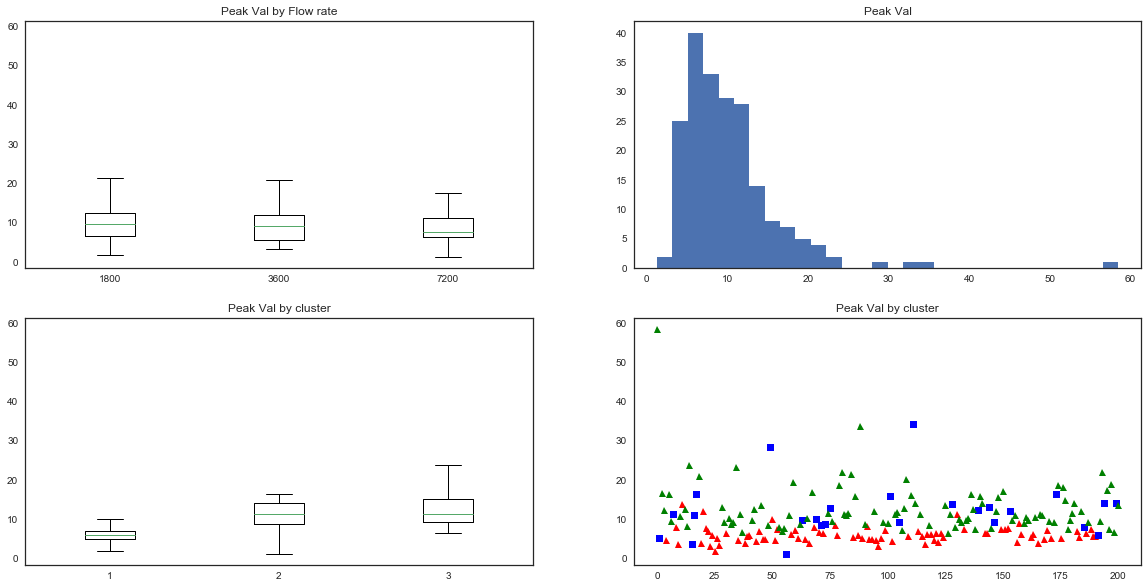

In [40]:
t = data[data['cluster']==0]['peak_val']
u = data[data['cluster']==1]['peak_val']
v = data[data['cluster']==2]['peak_val']

a = data[data['flow_rate']==1800]['peak_val']
b = data[data['flow_rate']==3600]['peak_val']
c = data[data['flow_rate']==7200]['peak_val']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Peak Val by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Peak Val")
plt.hist(data['peak_val'], bins=30)

plt.subplot(223)
plt.title("Peak Val by cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Peak Val by cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


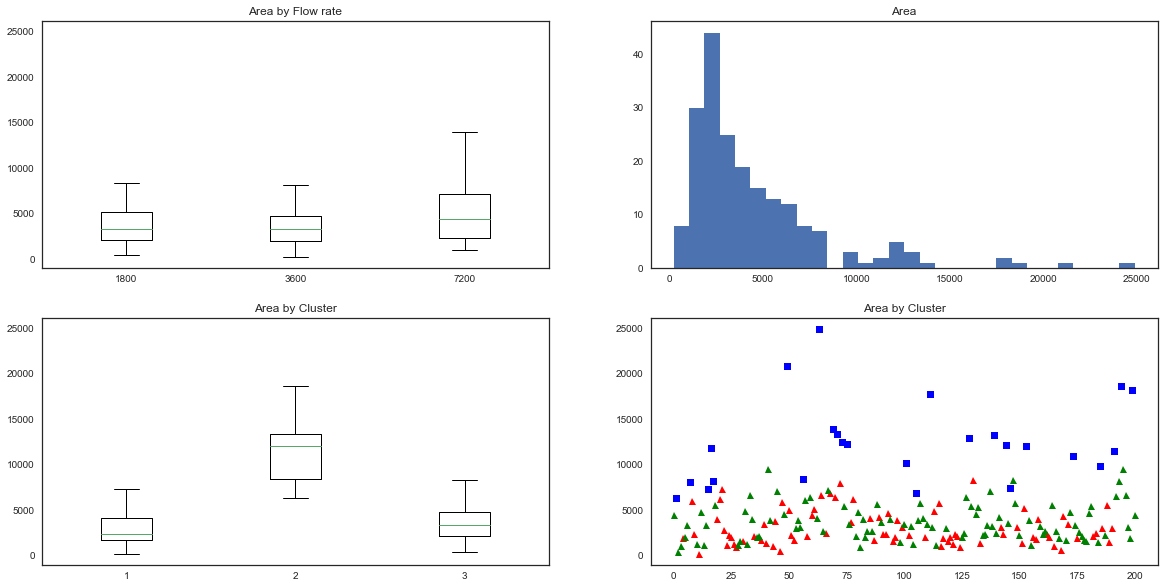

In [41]:
t = data[data['cluster']==0]['area']
u = data[data['cluster']==1]['area']
v = data[data['cluster']==2]['area']

a = data[data['flow_rate']==1800]['area']
b = data[data['flow_rate']==3600]['area']
c = data[data['flow_rate']==7200]['area']

# red dashes, blue squares and green triangles
#plt.plot(data[data['cluster']==0]['peak_val'], t, 'r--', u, u, 'bs', v, v, 'g^')
plt.subplot(221)
plt.title("Area by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Area")
plt.hist(data['area'], bins=30)

plt.subplot(223)
plt.title("Area by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Area by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


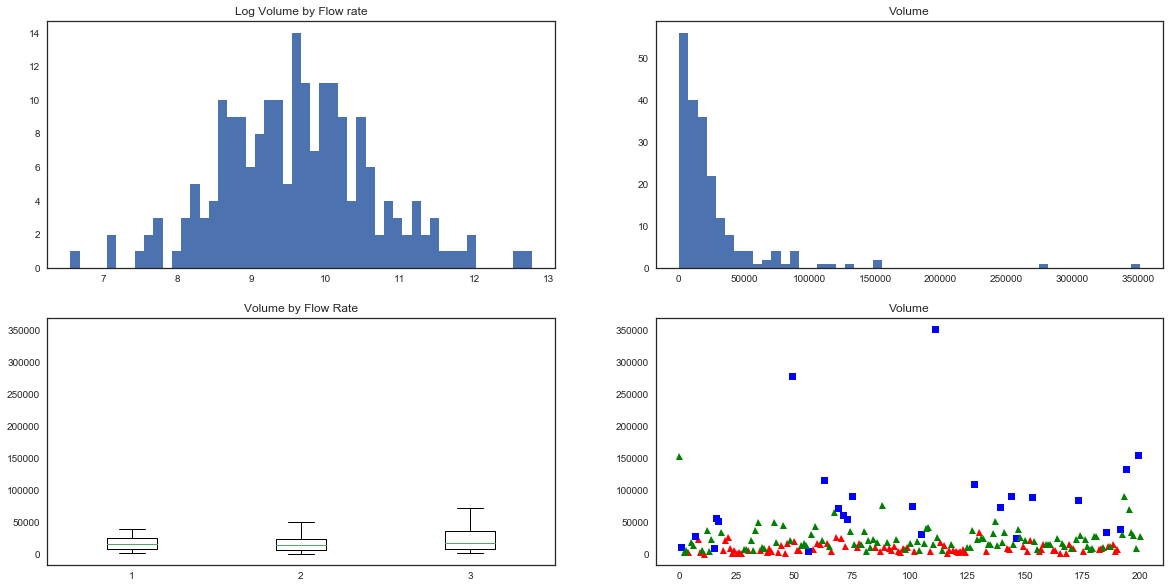

In [42]:
t = data[data['cluster']==0]['volume']
u = data[data['cluster']==1]['volume']
v = data[data['cluster']==2]['volume']

a = data[data['flow_rate']==1800]['volume']
b = data[data['flow_rate']==3600]['volume']
c = data[data['flow_rate']==7200]['volume']

log = data['volume'].apply(np.log)

plt.subplot(221)
plt.title("Log Volume by Flow rate")
#plt.boxplot([a,b,c], labels=['1800','3600','7200'])
plt.hist(log, bins=50)

plt.subplot(222)
plt.title("Volume")
plt.hist(data['volume'], bins=50)

plt.subplot(223)
plt.title("Volume by Flow Rate")
plt.boxplot([a,b,c], labels=['1','2','3'])

plt.subplot(224)
plt.title("Volume")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the focal distance (distance between focal points) over the major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


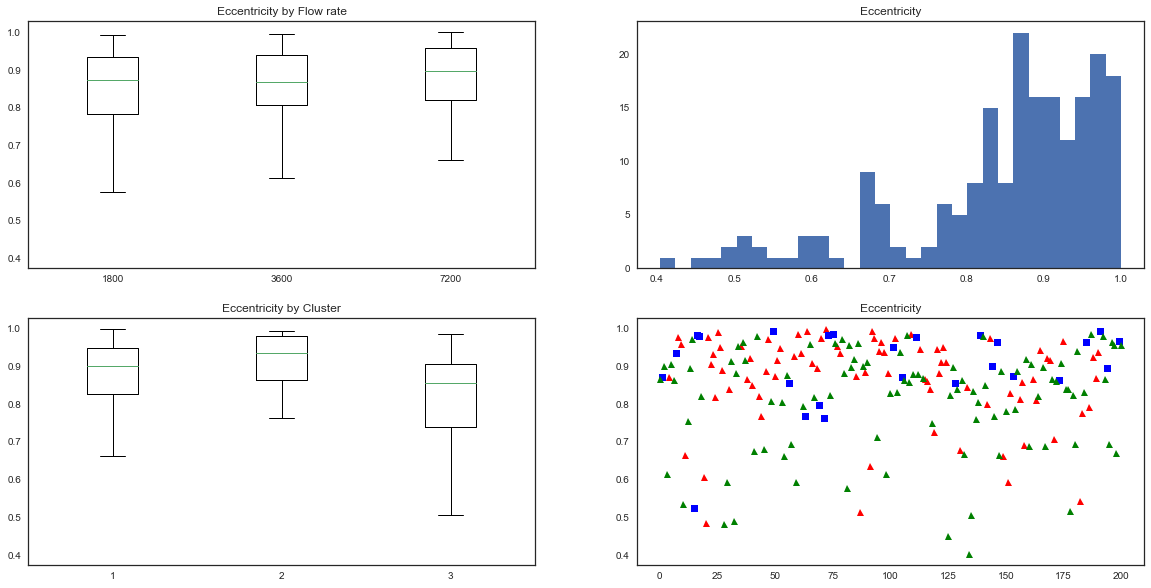

In [43]:
t = data[data['cluster']==0]['eccentricity']
u = data[data['cluster']==1]['eccentricity']
v = data[data['cluster']==2]['eccentricity']

a = data[data['flow_rate']==1800]['eccentricity']
b = data[data['flow_rate']==3600]['eccentricity']
c = data[data['flow_rate']==7200]['eccentricity']

plt.subplot(221)
plt.title("Eccentricity by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Eccentricity")
plt.hist(data['eccentricity'], bins=30)

plt.subplot(223)
plt.title("Eccentricity by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Eccentricity")
plt.plot(t, 'r^', u, 'bs', v, 'g^')


plt.show()

Euler characteristic of region. Computed as number of objects (= 1) subtracted by number of holes (8-connectivity).

Euler Number by Flow Rate: 
1800: [2, 3, 61]
3600: [4, 73]
7200: [3, 55]


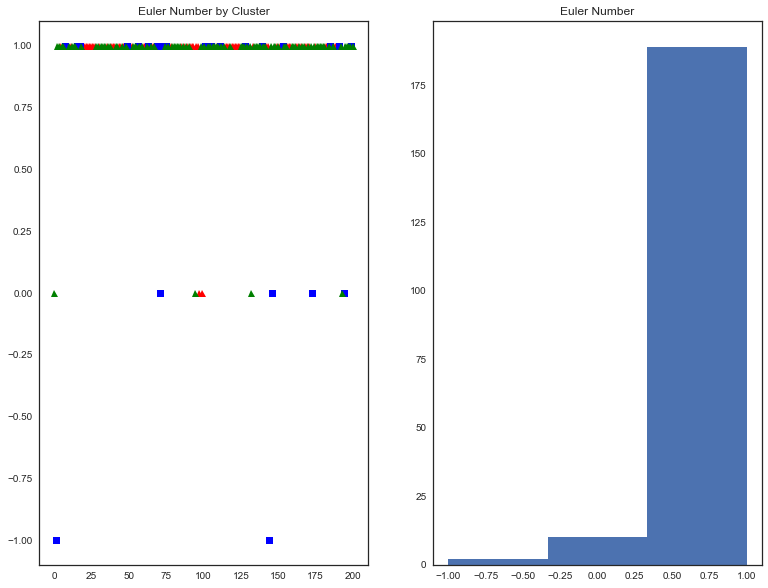

In [44]:
t = data[data['cluster']==0]['euler_number']
u = data[data['cluster']==1]['euler_number']
v = data[data['cluster']==2]['euler_number']

a = data[data['flow_rate']==1800]
a = a.groupby('euler_number').size().tolist()

b = data[data['flow_rate']==3600]
b = b.groupby('euler_number').size().tolist()

c = data[data['flow_rate']==7200]
c = c.groupby('euler_number').size().tolist()

print("Euler Number by Flow Rate: ")
print("1800: " + str(a))
print("3600: " + str(b))
print("7200: " + str(c))

'''plt.subplot(131)
plt.title("Euler Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])'''

plt.subplot(132)
plt.title("Euler Number by Cluster")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.subplot(133)
plt.title("Euler Number")
plt.hist(data['euler_number'], bins=3)

plt.show()

Ratio of pixels in the region to pixels in the total bounding box. Computed as area / (rows * cols)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


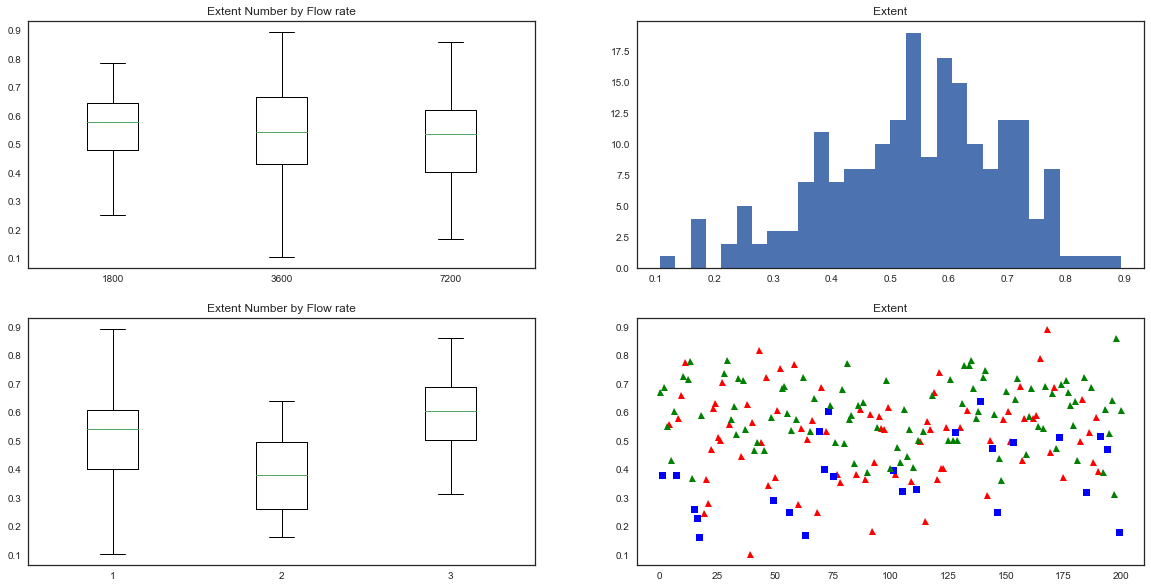

In [45]:
t = data[data['cluster']==0]['extent']
u = data[data['cluster']==1]['extent']
v = data[data['cluster']==2]['extent']

a = data[data['flow_rate']==1800]['extent']
b = data[data['flow_rate']==3600]['extent']
c = data[data['flow_rate']==7200]['extent']

plt.subplot(221)
plt.title("Extent Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Extent")
plt.hist(data['extent'], bins=30)

plt.subplot(223)
plt.title("Extent Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Extent")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


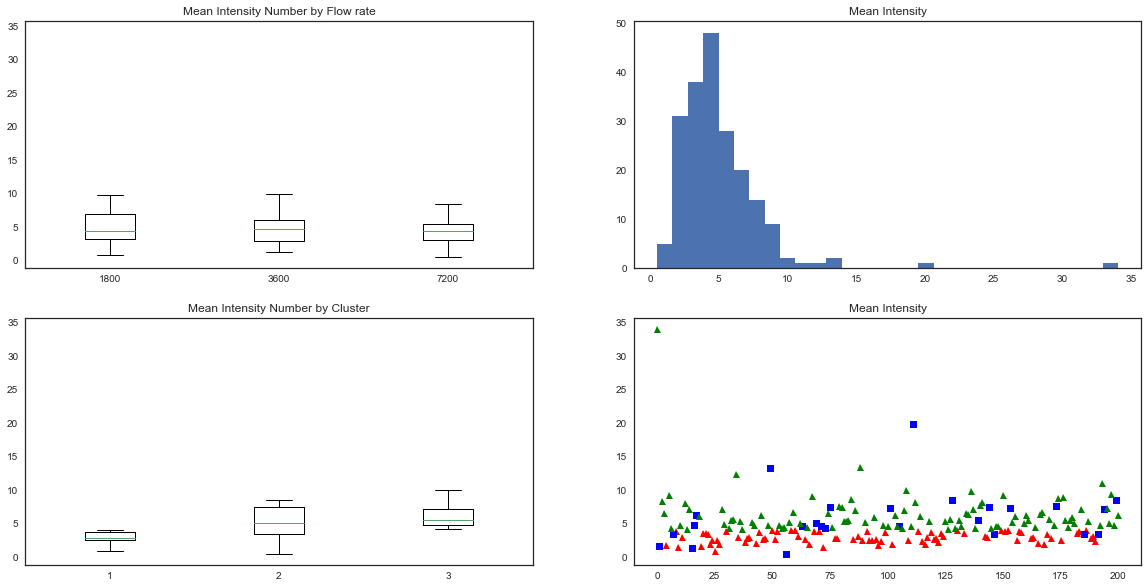

In [46]:
t = data[data['cluster']==0]['mean_intensity']
u = data[data['cluster']==1]['mean_intensity']
v = data[data['cluster']==2]['mean_intensity']

a = data[data['flow_rate']==1800]['mean_intensity']
b = data[data['flow_rate']==3600]['mean_intensity']
c = data[data['flow_rate']==7200]['mean_intensity']

plt.subplot(221)
plt.title("Mean Intensity Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Mean Intensity")
plt.hist(data['mean_intensity'], bins=30)

plt.subplot(223)
plt.title("Mean Intensity Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Mean Intensity")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

Angle between the X-axis and the major axis of the ellipse that has the same second-moments as the region. Ranging from -pi/2 to pi/2 in counter-clockwise direction.

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


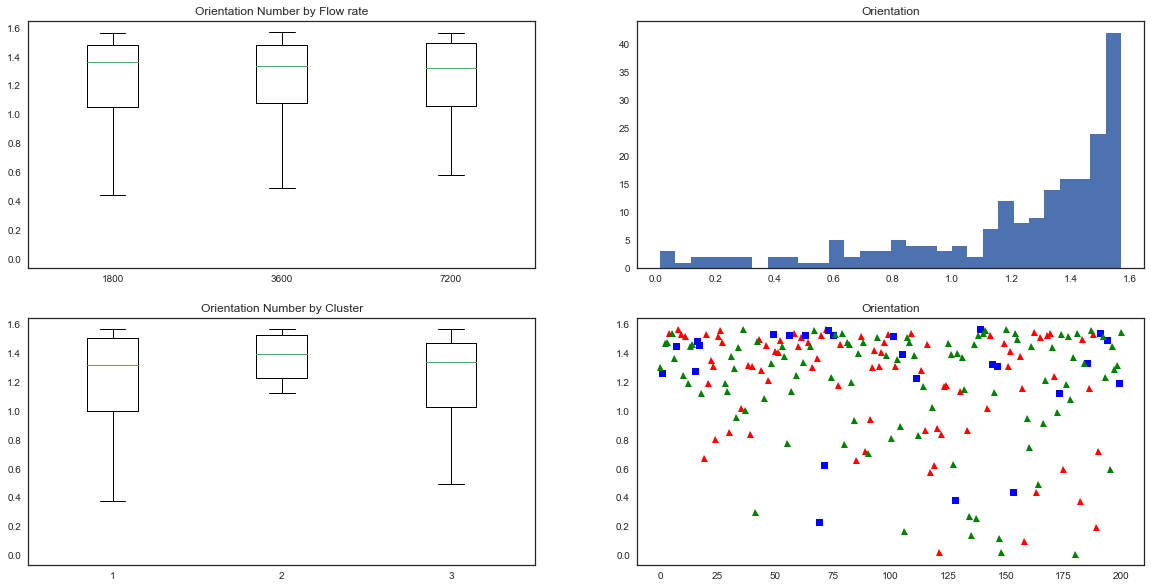

In [47]:
t = pd.DataFrame.abs(data[data['cluster']==0]['orientation'])
u = pd.DataFrame.abs(data[data['cluster']==1]['orientation'])
v = pd.DataFrame.abs(data[data['cluster']==2]['orientation'])

a = pd.DataFrame.abs(data[data['flow_rate']==1800]['orientation'])
b = pd.DataFrame.abs(data[data['flow_rate']==3600]['orientation'])
c = pd.DataFrame.abs(data[data['flow_rate']==7200]['orientation'])

plt.subplot(221)
plt.title("Orientation Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Orientation")
plt.hist(pd.DataFrame.abs(data['orientation']), bins=30)

plt.subplot(223)
plt.title("Orientation Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Orientation")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


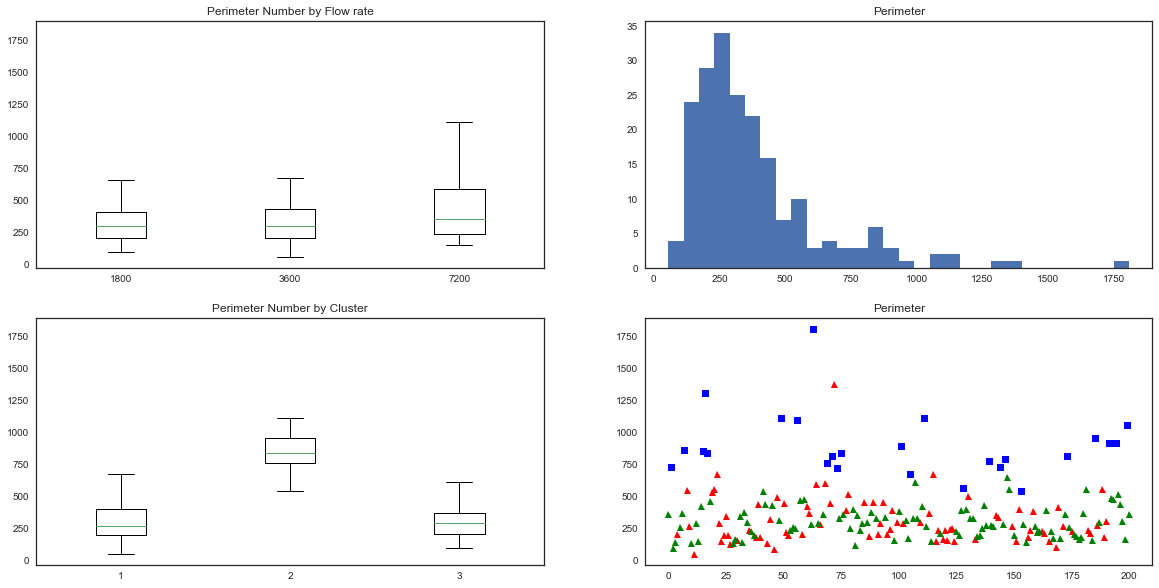

In [48]:
t = data[data['cluster']==0]['perimeter']
u = data[data['cluster']==1]['perimeter']
v = data[data['cluster']==2]['perimeter']

a = data[data['flow_rate']==1800]['perimeter']
b = data[data['flow_rate']==3600]['perimeter']
c = data[data['flow_rate']==7200]['perimeter']

plt.subplot(221)
plt.title("Perimeter Number by Flow rate")
plt.boxplot([a,b,c], labels=['1800','3600','7200'])

plt.subplot(222)
plt.title("Perimeter")
plt.hist(data['perimeter'], bins=30)

plt.subplot(223)
plt.title("Perimeter Number by Cluster")
plt.boxplot([t,u,v], labels=['1','2','3'])

plt.subplot(224)
plt.title("Perimeter")
plt.plot(t, 'r^', u, 'bs', v, 'g^')

plt.show()

In [49]:
#moments = data['moments'].as_matrix()
#print(moments)

for row in data['inertia_tensor']:
    print(row)
    #moments.append()

[[166.56046317 -51.3137445 ]
 [-51.3137445  133.56391191]]
[[437.4361069  310.68962085]
 [310.68962085 712.66061328]]
[[254.68080244 -15.23742976]
 [-15.23742976 515.77786234]]
[[2057.19053106 -586.58968096]
 [-586.58968096  852.87839211]]
[[ 222.11597891 -354.20156308]
 [-354.20156308 1377.25451785]]
[[1376.20149698 -186.98486249]
 [-186.98486249  838.60431051]]
[[ 142.00551806 -219.34986453]
 [-219.34986453 2144.50586223]]
[[ 45.70674264  11.54907397]
 [ 11.54907397 210.47554391]]
[[ 82.71136252  -4.63732992]
 [ -4.63732992 132.07131772]]
[[275.69940045 -79.13291678]
 [-79.13291678 143.39161697]]
[[ 69.16028272  52.51918318]
 [ 52.51918318 173.79436839]]
[[ 857.2969236  -257.27820962]
 [-257.27820962 4253.68174153]]
[[162.21083118  34.12511083]
 [ 34.12511083 445.83143276]]
[[121.83336195 -42.04748255]
 [-42.04748255 352.1534552 ]]
[[ 270.63453674 -119.65178639]
 [-119.65178639  471.80543969]]
[[65.86156881  2.89480545]
 [ 2.89480545 98.04511577]]
[[ 135.28370362 -122.912562  ]
 [-12

### Cluster sizes

In [50]:
print(len(data[data['cluster']==0]))
print(len(data[data['cluster']==1]))
print(len(data[data['cluster']==2]))

80
25
96


### Comparison of Manifold Algorithms

Source: http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

In [51]:
n_neighbors = 50
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (len(points), n_neighbors), fontsize=14)

X = standardize
color = data['flow_rate']

''' ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72) '''

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(257)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(258)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(259)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca',n_iter=5000, random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

TypeError: 'module' object is not callable

<Figure size 1080x576 with 0 Axes>

In [ ]:
perplexity = [5,10,30,50,100]

fig = plt.figure(figsize=(15, 8))
plt.suptitle("t-SNE Learning with %i points, %i neighbors by perplexity"
             % (len(points), n_neighbors), fontsize=14)

for i,p in enumerate(perplexity):
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, perplexity=p, init='pca',n_iter=5000, random_state=0)
    Y = tsne.fit_transform(X)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(251+i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("t-SNE (p:%d)" % (p))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

plt.show()

## Mutual Information

In [59]:
print(feature_selection.mutual_info_classif(samples.as_matrix(), data['flow_rate']))
print(list(train_data.head()))

[1.09437415 0.33133396 0.34490848 0.36516039 0.38596521 0.
 0.34448513 0.3552698  0.36167537 0.01716587 0.03522537 0.41149746
 0.09295179]
['peak_val', 'area', 'volume', 'eccentricity', 'euler_number', 'extent', 'mean_intensity', 'perimeter', 'cluster', 'num_peaks', 'sd', 'num_local_peaks']


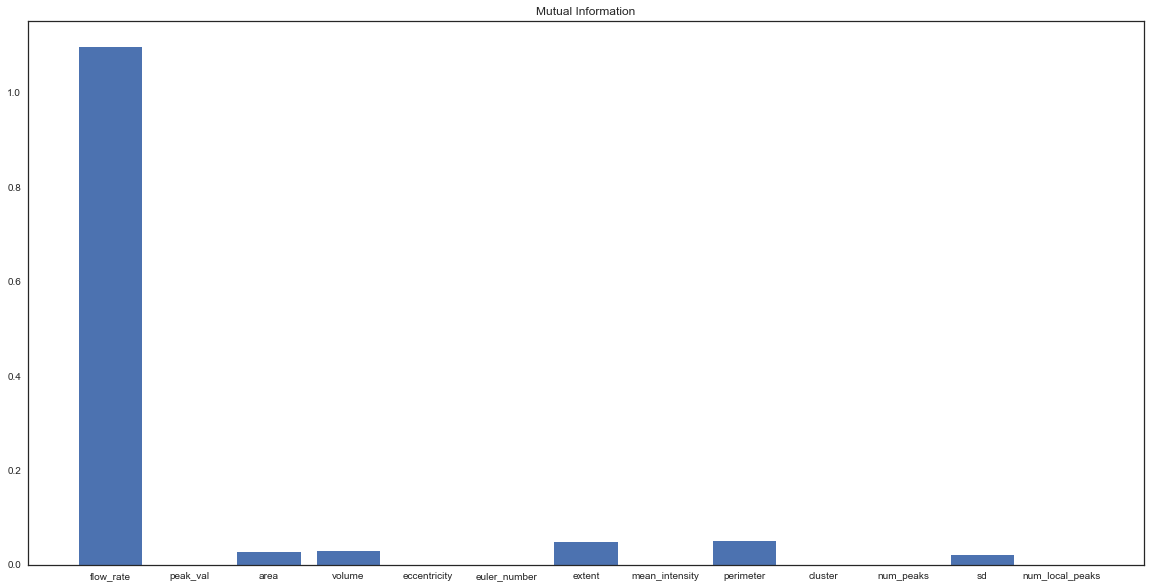

In [66]:
mi = feature_selection.mutual_info_classif(samples.as_matrix(), data['flow_rate'])
labels = list(samples.head())

x = np.arange(len(mi))

fig, ax = plt.subplots()
plt.title("Mutual Information")
plt.bar(x, mi)
plt.xticks(x, labels)

plt.show()